In [38]:
import glob
import math
import pandas as pd
import openslide
import numpy as np
import xml.etree.ElementTree as ET
from scipy.stats import percentileofscore
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

PROJECT_FOLDER = "Camelyon16"
ID = "tumor_102"

df = pd.read_csv(f"CompressionDecisionAgent/inferences/CompAgent_inference_task-{ID}_prob.csv")

df.loc[:, "X"] = None
df.loc[:, "Y"] = None

df.X = df.fname.map(lambda x: int(x.split("/")[-1].split("_")[-1].split("-")[0]))
df.Y = df.fname.map(lambda x: int(x.split("/")[-1].split("_")[-1].split("-")[1].split(".")[0]))

try:
    slide = openslide.OpenSlide(glob.glob(f"sample_dataset/{PROJECT_FOLDER}/{ID}/WSI/*.svs")[0])
except:
    slide = openslide.OpenSlide(glob.glob(f"sample_dataset/{PROJECT_FOLDER}/{ID}/WSI/*.tif")[0])
    
thumbnail = slide.get_thumbnail((1024, 1024))
thumbnail.save(f"Figures/thumbnail_{ID}.png")

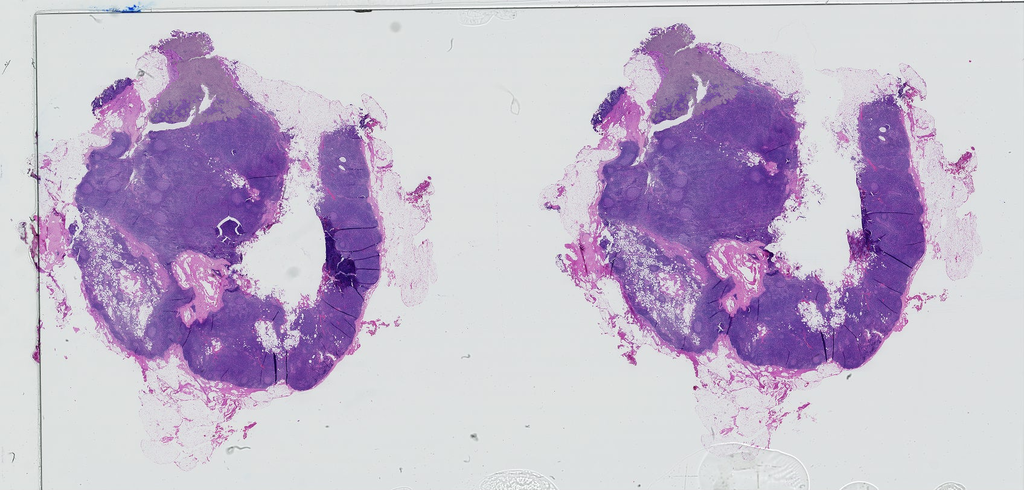

In [39]:
def parse_annotations(xml_file):
    """
    Parse the XML file to extract annotation coordinates.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []

    for annotation in root.findall(".//Annotation"):
        coords = []
        for coord in annotation.find("Coordinates"):
            x = float(coord.attrib["X"])
            y = float(coord.attrib["Y"])
            coords.append((x, y))
        annotations.append(coords)

    return annotations

def create_overlay(slide, xml_file, output_file, transparency=0.4):
    """
    Create an overlay image with annotations on the SVS thumbnail.
    """
    # Open the SVS file and extract the thumbnail
    thumbnail = slide.get_thumbnail((1024, 1024))  # Adjust size as needed

    # Parse the annotation XML
    annotations = parse_annotations(xml_file)

    # Create a transparent overlay
    overlay = Image.new("RGBA", thumbnail.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Draw annotations as a gray transparent mask
    for annotation in annotations:
        scaled_coords = [(x / slide.dimensions[0] * thumbnail.size[0],
                          y / slide.dimensions[1] * thumbnail.size[1])
                         for x, y in annotation]
        draw.polygon(scaled_coords, fill=(128, 128, 128, int(255 * transparency)))

    # Composite the overlay on top of the thumbnail
    result = Image.alpha_composite(thumbnail.convert("RGBA"), overlay)
    result.save(output_file)
    return result

# Path to the XML annotation file and WSI file
xml_file_path = glob.glob(f"sample_dataset/{PROJECT_FOLDER}/{ID}/Mask/*.xml")[0]
create_overlay(slide, xml_file_path, f"Figures/annotated_thumbnail_{ID}.png")

/tmp/ipykernel_2059023/2552071675.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdBu_r')


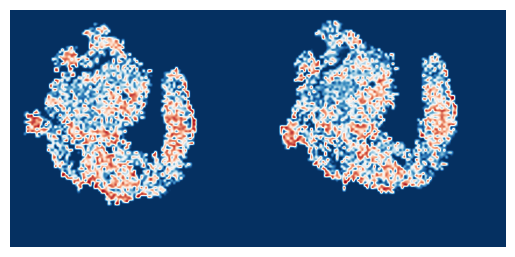

/tmp/ipykernel_2059023/2552071675.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdBu_r')


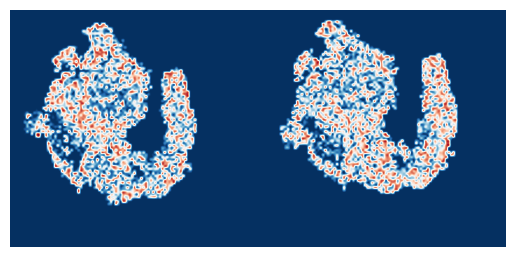

/tmp/ipykernel_2059023/2552071675.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdBu_r')


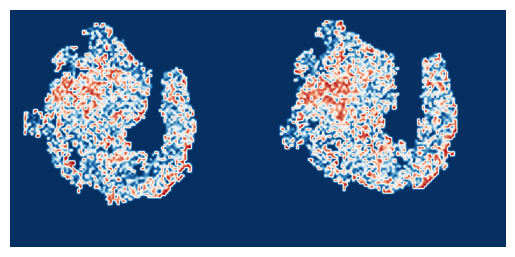

In [40]:
# 점수 -> 백분위수 변환 함수 정의
def score2percentile(score, ref):
    percentile = percentileofscore(ref, score)
    return percentile

for cond_text, cond in zip(["lambda_010", "lambda_050", "lambda_100"], [df.lambda_010, df.lambda_050, df.lambda_100]):
    # 빈 배열 생성
    temp = np.zeros((slide.dimensions[0] // 1024 + 1, slide.dimensions[1] // 1024 + 1)).astype(np.uint8)

    # 데이터를 백분위수로 변환하여 temp 배열 채우기
    for i, row in df.iterrows():
        percentile = score2percentile(row[cond_text], cond)
        temp[row.X // 1024, row.Y // 1024] = percentile

    # PIL 이미지를 통해 temp 배열 변환
    temp = Image.fromarray(temp)
    temp = temp.transpose(method=Image.Transpose.ROTATE_270).transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
    temp = temp.resize(thumbnail.size)
    temp.convert("RGBA")
    
    # RGBA로 변환
    # temp = temp.convert("RGBA")

    # matplotlib 컬러맵 적용
    cmap_reversed = plt.cm.get_cmap('RdBu_r')

    # 결과 이미지 저장 및 시각화
    plt.imshow(temp, cmap=cmap_reversed)
    plt.axis("off")
    
    plt.savefig(f"Figures/Heatmap_{ID}_{cond_text}.png", dpi=300)
    plt.show()